$$
H = H^{XX} + H^{YY} + H^{ZZ} + H^{Z}
$$
where
$$
H^{XX} = \text{x}\sum_{n=0}^{N-2} X_n X_{n+1}
$$
$$
H^{YY} = \text{x}\sum_{n=0}^{N-2} Y_n Y_{n+1}
$$
$$
H^{ZZ} = \frac{1}{4}\sum_{n=0}^{N-2}\sum^{n}_{m\neq k} Z_m Z_k
$$
$$
H^{Z} = \frac{\mu}{2}\sum_{n=0}^{N-1}(-1)^{n+1}Z_n + \mathcal{E}_0\sum_{n=0}^{N-2}\sum_{m=0}^n Z_m - \frac{1}{2}\sum_{n=0}^{N-2}\sum_{m\neq k}^n (-1)^m Z_k
$$

In [1]:
import numpy as np
from qiskit.quantum_info import SparsePauliOp

e0 = 0
x = 0.6
mu = 0.1

N=4

def H_schwinger(x, mu):
    """
    Constructs the Hamiltonian for the Schwinger model with N sites.
    """
    HXX = SparsePauliOp(['XXII', 'IXXI', 'IIXX'], coeffs = [0.5*x]*3)
    HYY = SparsePauliOp(['YYII', 'IYYI', 'IIYY'], coeffs = [0.5*x]*3)
    HZZ = SparsePauliOp(['ZZII', 'ZIZI', 'IZZI'], coeffs = [1, 0.5, 0.5])
    HZ1 = SparsePauliOp(['-1ZIII', 'IZII', '-1IIZI', 'IIIZ'], coeffs = [0.5*mu]*4)
    #HZ2 = SparsePauliOp([], coeffs = [e0]*3)
    HZ3 = SparsePauliOp(['ZIII', 'ZIII', 'IZII', 'IIZI'], coeffs = [-0.5]*4)
    H_shift = SparsePauliOp(['I'*N], coeffs=[2])
    
    return HXX + HYY + HZZ + HZ1 + HZ3 + H_shift


In [2]:
# strong vacuum state
eigvals, eigvecs = np.linalg.eigh(H_schwinger(0, mu).to_matrix())
initial_state = eigvecs[np.argmin(eigvals)]
initial_state, eigvals

(array([0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j]),
 array([-0.2, -0.1,  0.9,  1. ,  1. ,  1. ,  1.1,  1.1,  1.9,  2. ,  2.1,
         2.2,  2.9,  3. ,  6. ,  6.1]))

In [3]:
H = H_schwinger(x, mu)
H_matrix = H.to_matrix()

E_vals = np.sort(np.linalg.eigvalsh(H_matrix))
E_vals

array([-0.84487809, -0.55591798,  0.62550611,  0.7470235 ,  0.88259793,
        1.        ,  1.34238256,  1.40926326,  1.9913733 ,  2.        ,
        2.26405679,  2.34697392,  3.17141253,  3.40849811,  6.        ,
        6.21170807])

In [4]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.synthesis import LieTrotter, SuzukiTrotter

# part c

def get_final_state(H, initial_state, time, trotterization_order=1):
    if trotterization_order == 1:
        trotterization = LieTrotter(10)
    elif trotterization_order > 1:       
        trotterization = SuzukiTrotter(10)
    else:
        raise ValueError("Trotterization order must be greater than 0.")
    
    evo = PauliEvolutionGate(H, time=time, synthesis=trotterization)
    
    final_state = initial_state.evolve(evo)

    return final_state

In [ ]:
import matplotlib.pyplot as plt
from tqdm import tqdm


t = np.linspace(0, 5, 100)
initial_state = Statevector(initial_state)
echo_order1 = []
echo_order2 = []
fs_density_order1 = []
fs_density_order2 = []

V = SparsePauliOp(['IIII', '-1ZIII', 'IZII', '-1IIZI', 'IIIZ'], coeffs = [0.5]+[0.125]*4)
for ti in tqdm(t):
    final_state = get_final_state(H, initial_state, ti, trotterization_order=1)
    echo_order1.append(np.abs(final_state.inner(initial_state))**2)
    fs_density_order1.append(final_state.expectation_value(V))
    final_state = get_final_state(H, initial_state, ti, trotterization_order=2)
    echo_order2.append(np.abs(final_state.inner(initial_state))**2)
    fs_density_order2.append(final_state.expectation_value(V))

100%|██████████| 10/10 [00:13<00:00,  1.36s/it]


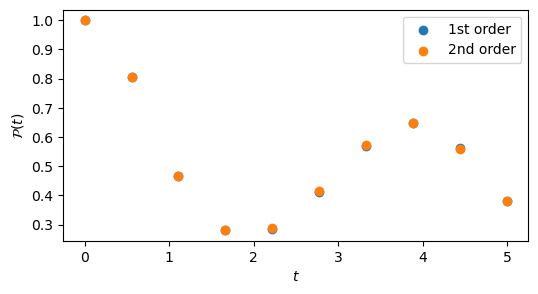

In [11]:
plt.figure(figsize=(6,3))

plt.scatter(t, echo_order1, label='1st order')
plt.scatter(t, echo_order2, label='2nd order')
plt.xlabel(r'$t$')
plt.ylabel(r'$\mathcal{P}(t)$')
plt.legend()
plt.show()

/home/pablo/miniconda3/envs/vqiskit/lib/python3.13/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/pablo/miniconda3/envs/vqiskit/lib/python3.13/site-packages/matplotlib/collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


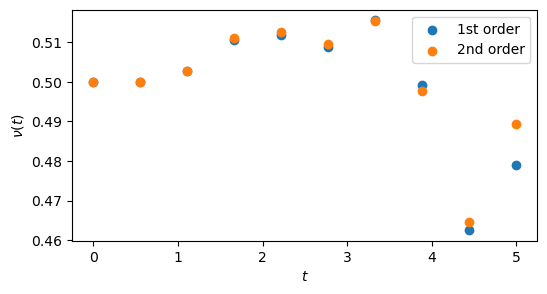

In [13]:
plt.figure(figsize=(6,3))

plt.scatter(t, fs_density_order1, label='1st order')
plt.scatter(t, fs_density_order2, label='2nd order')
plt.xlabel(r'$t$')
plt.ylabel(r'$\nu(t)$')
plt.legend()
plt.show()